In [1]:
import anndata
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
from ALLCools.clustering import tsne
from ALLCools.plot import *
from scipy.sparse import csr_matrix
from wmb import brain
import joblib

In [2]:
#cemba_snmc_cells = pd.read_csv('mc_cells.txt', index_col=0, header=None).index
cemba_snmc_cells = anndata.read_h5ad('mc_pc.h5ad').obs_names
cemba_snmc_pc = np.load("snmc_and_snm3c.integration.npz")["snmc"]

#cemba_snm3c_cells = pd.read_csv('m3c_cells.txt', index_col=0, header=None).index
cemba_snm3c_cells = anndata.read_h5ad('m3c_pc.h5ad').obs_names
cemba_snm3c_pc = np.load("snmc_and_snm3c.integration.npz")["snm3c"]

#cemba_atac_cells = pd.read_csv('atac_cells.txt', index_col=0, header=None).index
cemba_atac_cells = anndata.read_h5ad('atac_pc.h5ad').obs_names
cemba_atac_pc = np.load("snmc_atac.5kb_integration.npz")['atac_5k']

#multiome_cells = pd.read_csv('multiome_cells.txt', index_col=0, header=None).index
multiome_cells = anndata.read_h5ad('multiome_pc.h5ad').obs_names
multiome_pc = np.load("snmc_multiome.5kb_integration.npz")['multiome_5k']

In [3]:
len(cemba_snmc_cells), len(cemba_snm3c_cells), len(cemba_atac_cells) , len(multiome_cells)

(120695, 48519, 450987, 206787)

In [4]:
use_var = joblib.load('use_var_list')

In [5]:
records = {
    "snmC": {"cells": cemba_snmc_cells, "pcs": cemba_snmc_pc},
    "snm3C": {"cells": cemba_snm3c_cells, "pcs": cemba_snm3c_pc},
    "ATAC": {"cells": cemba_atac_cells, "pcs": cemba_atac_pc},
    "Multiome": {"cells": multiome_cells, "pcs": multiome_pc},
}
n_modalities = len(records)

all_cells = []
counts = []
modalities = []
all_pcs = []
for k, v in records.items():
    modalities.append(k)
    all_cells += v["cells"].tolist()
    counts.append(len(v["cells"]))
    all_pcs.append(v["pcs"])
    
all_pcs = np.concatenate(all_pcs)
modalities = np.repeat(modalities, counts)
all_cells = pd.Index(all_cells)

obs = pd.DataFrame({"Modalities": modalities}, index=all_cells)
var = pd.DataFrame([], index=use_var)
var.index.name = "chrom5k"
adata = anndata.AnnData(
    X=csr_matrix((obs.shape[0], var.shape[0])),
    obs=obs,
    var=var,
    obsm={"X_pca": all_pcs},
)
adata

AnnData object with n_obs × n_vars = 826988 × 272436
    obs: 'Modalities'
    obsm: 'X_pca'

In [6]:
adata

AnnData object with n_obs × n_vars = 826988 × 272436
    obs: 'Modalities'
    obsm: 'X_pca'

In [7]:
tsne(adata, obsm="X_pca")

In [8]:
sc.pp.neighbors(adata, use_rep="X_pca")
sc.tl.leiden(adata, resolution=1)

In [9]:
adata.write_h5ad("final_with_coords.atac_correct.h5ad")

In [10]:
modality_palette = {
    "snmC": "#ca5572",
    "snm3C": "#72a553",
    "ATAC": "#c57c3d",
    "Multiome": "#6097ce",
}

In [11]:
_dir = '/home/qzeng_salk_edu/project/231120-integration-all'
mc_meta = pd.read_csv(f'{_dir}/fixed_mc_meta.csv', index_col = 0).loc[cemba_snmc_cells]
m3c_meta = pd.read_csv(f'{_dir}/fixed_m3c_meta.csv', index_col = 0).loc[cemba_snm3c_cells]
atac_meta = pd.read_csv(f'{_dir}/fixed_atac_meta.csv', index_col =0).loc[cemba_atac_cells]
multiome_meta = pd.read_csv(f'{_dir}/fixed_multiome_meta.csv', index_col =0).loc[multiome_cells]

In [12]:
annot = pd.concat([
    mc_meta[['CellType']],
    m3c_meta[['CellType']],
    atac_meta[['CellType']],
    multiome_meta[['CellType']],
])

In [13]:
adata.obs['CellType'] = annot['CellType']

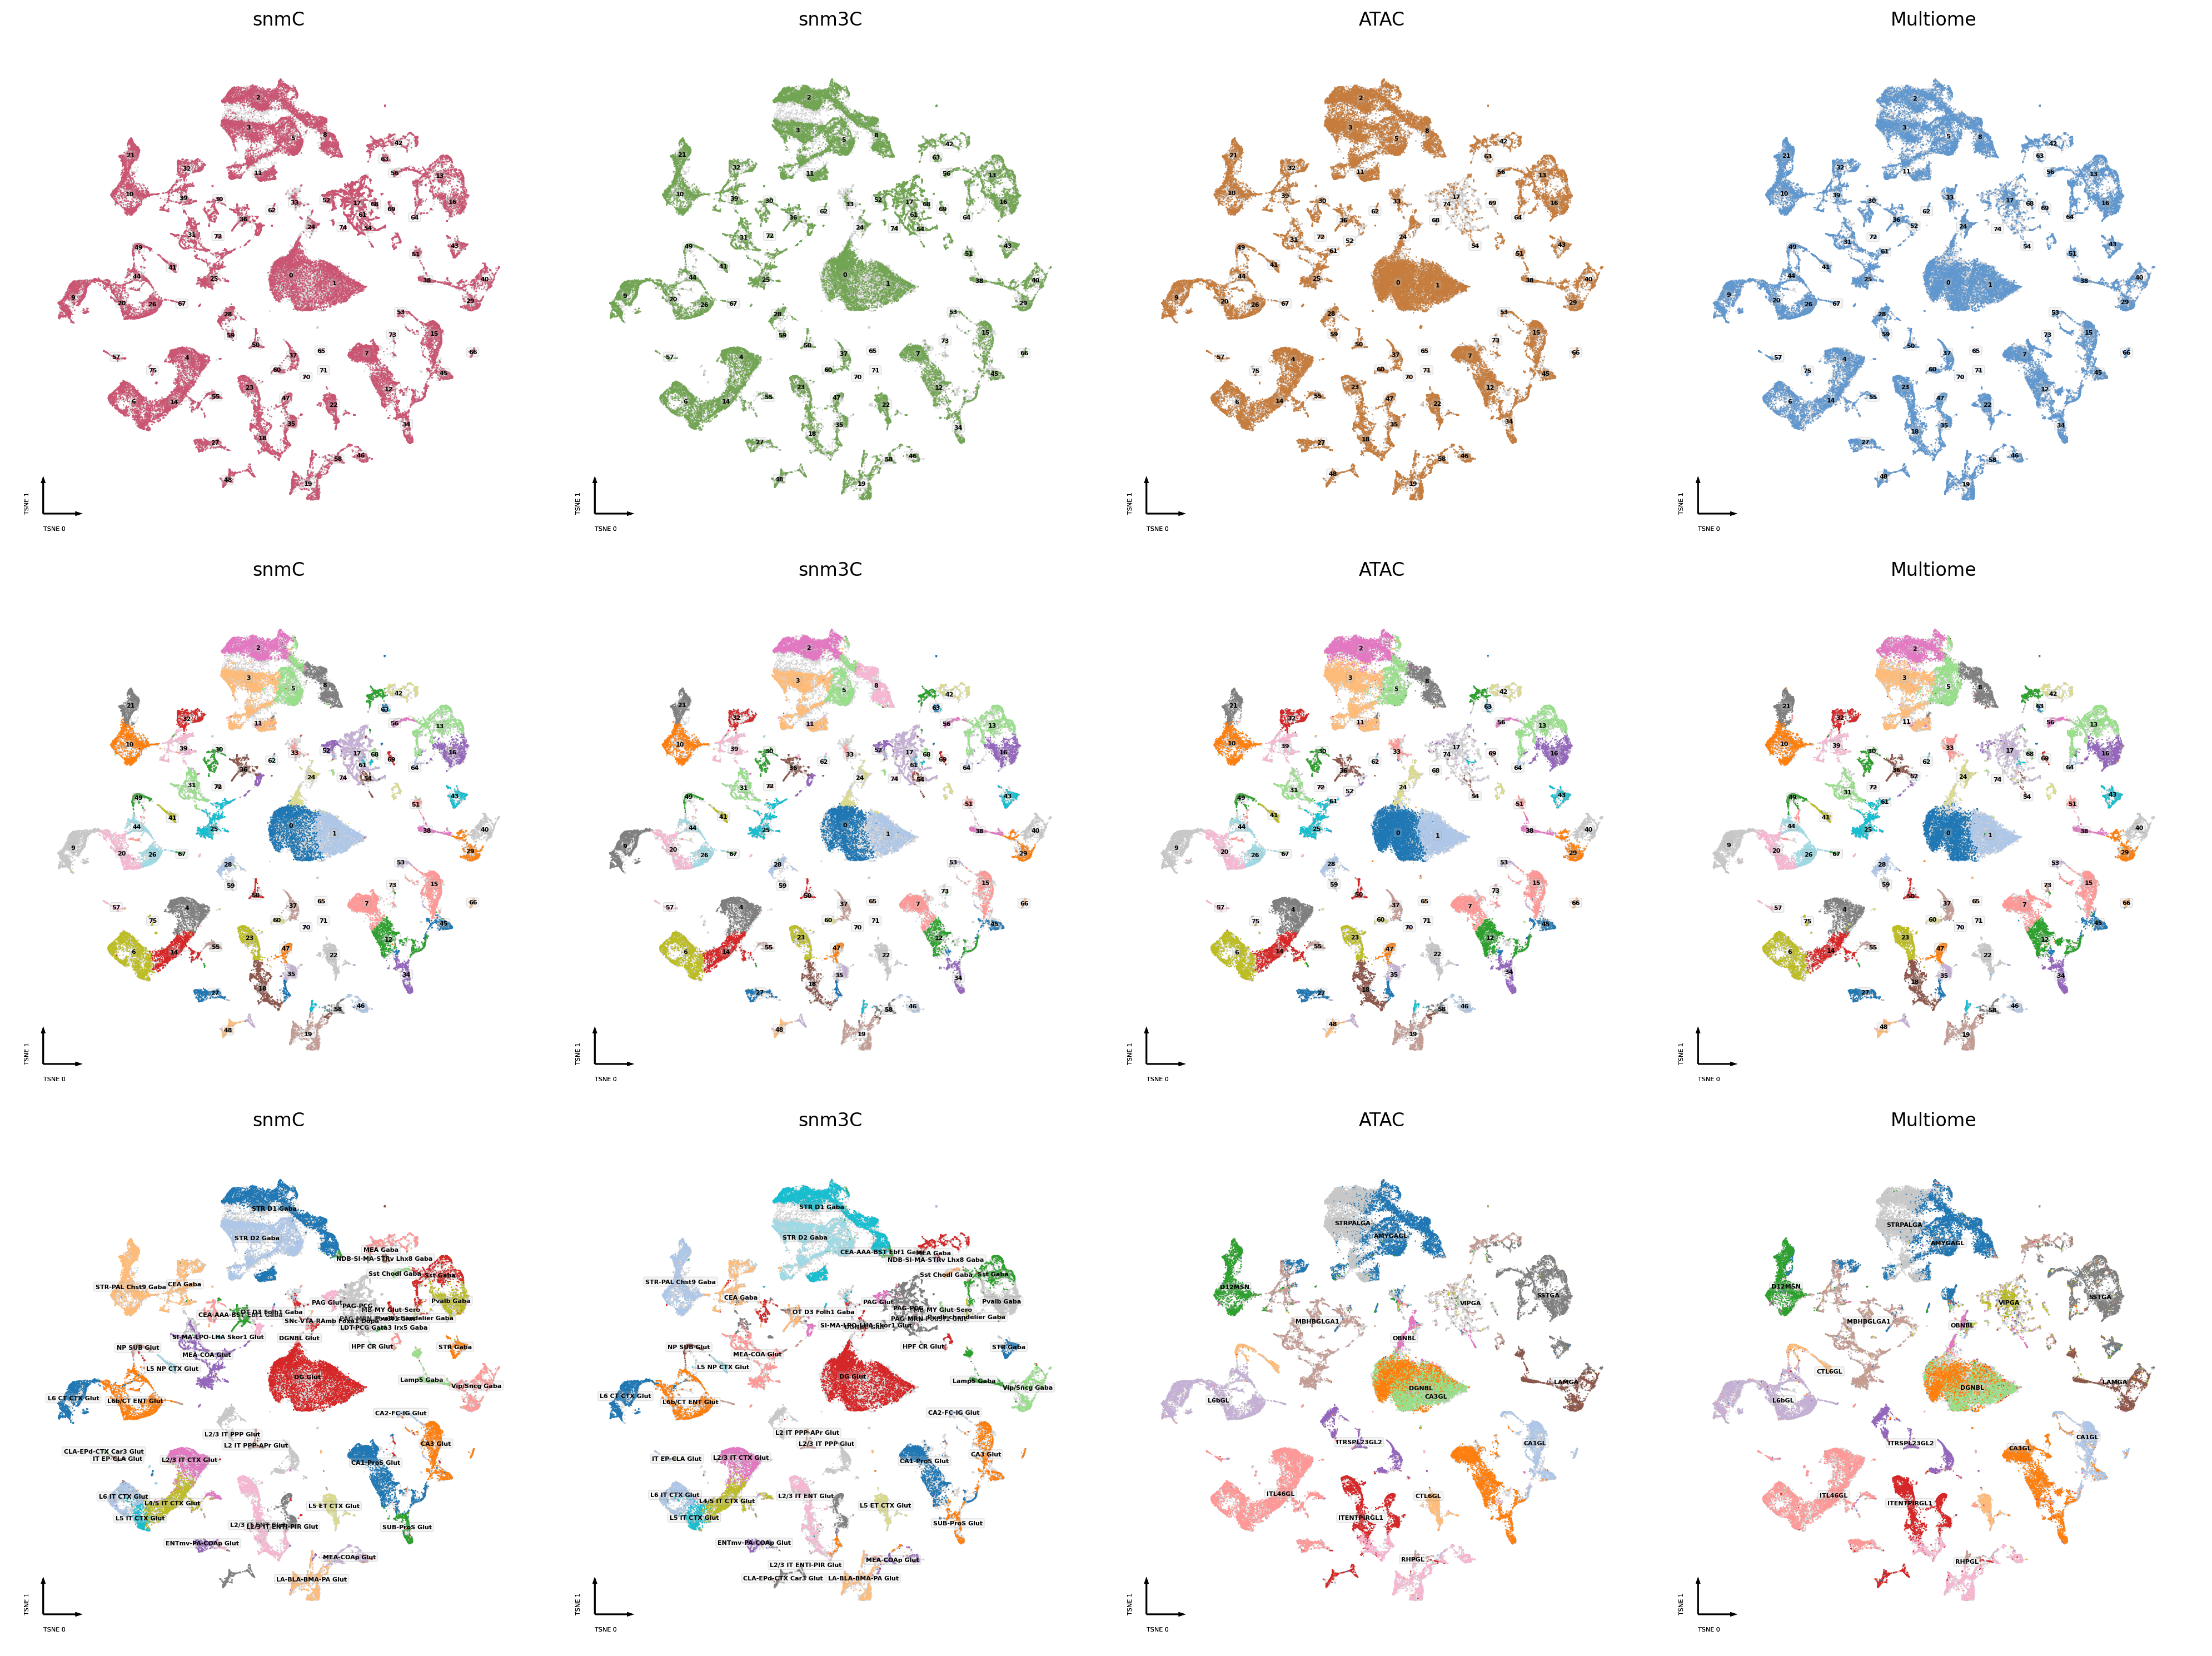

In [15]:
import matplotlib.pyplot as plt

# Create a subplot with 2 rows and 4 columns
fig, axes = plt.subplots(figsize=(20, 15), nrows=3, ncols=4, dpi=200)

# Iterate over each modality and plot in the respective subplot
for i, modality in enumerate(modality_palette.keys()):
    # Top row plots
    ax_top = axes[0, i]
    categorical_scatter(data=adata, ax=ax_top, color="lightgrey", coord_base="tsne")
    categorical_scatter(
        data=adata[adata.obs["Modalities"] == modality],
        ax=ax_top,
        color=modality_palette[modality],
        coord_base="tsne",
        text_anno='leiden'
    )
    ax_top.set_title(modality)

    # Bottom row plots
    ax_middle = axes[1, i]
    categorical_scatter(data=adata, ax=ax_middle, color="lightgrey", coord_base="tsne")
    categorical_scatter(
        data=adata[adata.obs["Modalities"] == modality],
        ax=ax_middle,
        hue='leiden',
        text_anno='leiden',
        palette='tab20',
        coord_base="tsne",
    )
    ax_middle.set_title(modality)
    
    ax_bottom = axes[2, i]
    categorical_scatter(data=adata, ax=ax_bottom, color="lightgrey", coord_base="tsne")
    categorical_scatter(
        data=adata[adata.obs["Modalities"] == modality],
        ax=ax_bottom,
        hue='CellType',
        text_anno='CellType',
        palette='tab20',
        coord_base="tsne",
    )
    ax_bottom.set_title(modality)

plt.tight_layout()
plt.show()
